In [6]:
import pandas as pd
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
import random
import os
import gc 

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader

In [2]:
def print_memory(): 
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(t, r, a)

In [3]:
print_memory()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [7]:
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')

In [8]:
def create_aggregated_dataframe(sales_train_evaluation):
    # Columns to aggregate are d_1 to d_1942
    cols_to_agg = [f'd_{i}' for i in range(1, 1942)]

    # defines how we are grouping 
    group_cols = [
        ['state_id'],
        ['store_id'],
        ['cat_id'],
        ['dept_id'],
        ['state_id', 'cat_id'],
        ['state_id', 'dept_id'],
        ['store_id', 'cat_id'],
        ['store_id', 'dept_id'],
        ['item_id'],
        ['item_id', 'state_id']
    ]
    
    # Create a copy of the original DataFrame to start aggregating into
    aggregated_df = sales_train_evaluation.copy()
    aggregated_df['Hierarchy Level'] = len(group_cols)  # Set NaN for original data

    # Store the indices of the original rows
    original_indices = np.arange(len(aggregated_df))

    # Perform aggregation and append to the original DataFrame
    hierarchy_level = 0
    appended_data = []
    for group in group_cols:
        group_df = sales_train_evaluation.groupby(group)[cols_to_agg].sum().reset_index()
        group_df['Hierarchy Level'] = hierarchy_level
        appended_data.append(group_df)
        hierarchy_level += 1

    # Append all aggregated data in the order of hierarchy (lower index first)
    aggregated_df = pd.concat([aggregated_df] + appended_data, ignore_index=True)
    
    # Sort DataFrame by 'Hierarchy Level'
    aggregated_df.reset_index(drop=True, inplace=True)

    # Create an empty aggregation matrix
    n_rows = len(aggregated_df)
    agg_matrix = np.zeros((n_rows, n_rows), dtype=int)

    # Mark original rows (self aggregation)
    np.fill_diagonal(agg_matrix[:len(original_indices), :len(original_indices)], 1)

    # Fill in the aggregation matrix for the appended rows
    new_index_offset = len(original_indices)
    for group in group_cols:
        group_indices = sales_train_evaluation.groupby(group).apply(lambda x: x.index.tolist()).tolist()
        for sub_indices in group_indices:
            agg_matrix[new_index_offset, sub_indices] = 1
            new_index_offset += 1

    return aggregated_df, agg_matrix

In [9]:
agg_df, agg_matrix = create_aggregated_dataframe(sales_train_evaluation)

In [10]:
cols_to_agg = [f'd_{i}' for i in range(1, 1942)]

In [11]:
data = agg_df[cols_to_agg].T

maximum = np.max(data.values)
data_scaled = (data / maximum).values

seed = 0 

def set_seeds(seed): 
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # if using nvidia gpu
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

set_seeds(seed)

In [12]:
data_scaled.shape

(1941, 42839)

In [13]:
n_series = data.shape[1] 
n_total = data.shape[0]
n_train = 1400
context_window = 2
n_val = 150

data.shape

(1941, 42839)

In [14]:
def calculate_wmape(actual_values, forecasted_values):
    # compute wMAPE metric
    n = len(actual_values)
    num = np.sum(np.abs(actual_values - forecasted_values))
    den = np.sum(np.abs(actual_values))
    wmape = num/den
    return wmape

def calculate_RMSE(actual_values, forecasted_values): 
    # compute RMSE metric
    squared_errors = (actual_values - forecasted_values) ** 2
    mean_squared_error = np.mean(squared_errors)
    rmse = np.sqrt(mean_squared_error)
    return rmse

(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]),
 [Text(-250.0, 0, '−250'),
  Text(0.0, 0, '0'),
  Text(250.0, 0, '250'),
  Text(500.0, 0, '500'),
  Text(750.0, 0, '750'),
  Text(1000.0, 0, '1000'),
  Text(1250.0, 0, '1250'),
  Text(1500.0, 0, '1500'),
  Text(1750.0, 0, '1750'),
  Text(2000.0, 0, '2000'),
  Text(2250.0, 0, '2250')])

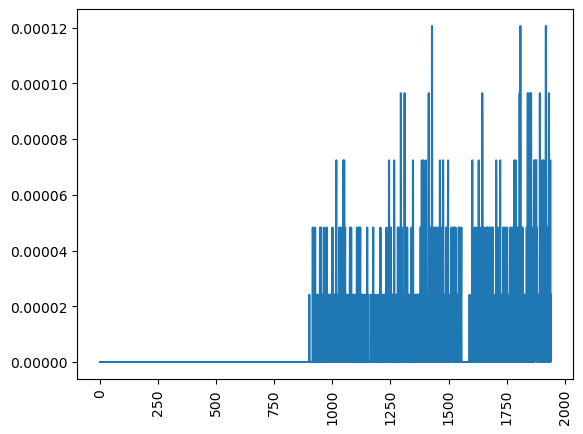

In [15]:
plt.plot(data_scaled[:,0])
plt.xticks(rotation=90)

In [16]:
def make_data(dataset, range_, context_window): 
    # produces X_data and y_data tensors given the dataset 
    X_data = []
    y_data = []
    for i in range_:
        X = dataset[i:i+context_window,:].T.flatten()
        X_data.append(X)

        y = dataset[i+context_window:i+context_window+1,:].T.flatten()
        y_data.append(y)

    return torch.tensor(X_data, dtype=torch.float32), torch.tensor(y_data, dtype=torch.float32)

In [17]:
class Dataset_M5(Dataset):
    def __init__(self, root_path, flag='train', context_window=context_window, n_train=n_train, n_val=n_val, seq_len=n_train-context_window):
        
        # init
        self.root_path = root_path
        self.context_window=context_window
        self.n_train = n_train
        self.n_val = n_val
        self.seq_len = seq_len
        
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.__read_data__()

    def __read_data__(self):
        df_raw = agg_df[cols_to_agg].T
        maximum = np.max(df_raw.values)
        data = (df_raw / maximum).values
        
        X_data = []
        y_data = []

        if self.set_type == 0: 
            data_range = range(self.n_train)
        elif self.set_type == 1: 
            data_range = range(self.n_train, self.n_train + self.n_val)
        else: 
            data_range = range(self.n_train + self.n_val, self.data.shape[0] - self.context_window)

        for i in data_range:
            X = data[i:i+self.context_window,:].T.flatten()
            X_data.append(X)

            y = data[i+self.context_window:i+self.context_window+1,:].T.flatten()
            y_data.append(y)

        self.X = torch.tensor(np.array(X_data)).float()
        self.y = torch.tensor(np.array(y_data)).float()

    def __getitem__(self, index):
        X = self.X[index:index + self.seq_len, :]
        y = self.y[index:index + self.seq_len]
        
        return X, y

    def __len__(self):
        return len(self.X) - context_window - self.seq_len + 1

In [18]:
train_dataset = Dataset_M5('/home/gridsan/mhensgen/m5', seq_len=50)

In [19]:
train_dataset[0][0].shape

torch.Size([50, 85678])

In [20]:
train_dataset.X.dtype

torch.float32

In [21]:
X_train, y_train = make_data(data_scaled, range(n_train), context_window)
X_val, y_val = make_data(data_scaled, range(n_train, n_train+n_val), context_window)
X_test, y_test = make_data(data_scaled, range(n_train + n_val,n_total - context_window), context_window)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

/state/partition1/slurm_tmp/25983519.0.0/ipykernel_1262672/3537104489.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(X_data, dtype=torch.float32), torch.tensor(y_data, dtype=torch.float32)


torch.Size([1400, 85678])
torch.Size([150, 85678])
torch.Size([389, 85678])


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_level_0 = agg_df[agg_df['Hierarchy Level'] == 10].shape[0]

aggregation_mat = torch.from_numpy(agg_matrix[num_level_0:, :]).float().to(device)
S = agg_matrix[:, :num_level_0]

def coherency_loss(network): 
    # computes coherency on last layer of the network 
    return torch.norm(aggregation_mat @ network.last_layer.weight - network.last_layer.weight[num_level_0:, :]) + torch.norm(
        aggregation_mat @ network.last_layer.bias - network.last_layer.bias[num_level_0:]) 

def coherency_metric(predictions):
    # computes the actual coherency of predictions 
    return torch.norm(predictions.T[num_level_0:, :] - aggregation_mat @ predictions.T) / predictions.shape[1]

cpu


In [23]:
print_memory()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
def create_M(S): 
    # creates the projection matrix M given the aggregation matrix S
    m, m_K = S.shape
    m_agg = m-m_K

    # The top `m_agg` rows of the matrix `S` give the aggregation constraint matrix.
    S_agg = S[num_level_0:, :]
    A = np.hstack((-S_agg, np.eye(m_agg)))

    M = torch.eye(m) - torch.from_numpy(A.T @ np.linalg.pinv(A @ A.T) @ A).float().to(device)

    return M, A

M, A = create_M(S)

def project_samples(y): 
    return torch.matmul(y, M)


def least_squares_loss(predictions): 
    # computes the projections and then takes least squares loss between predictions and projections 
    # predictions should have shape n_samples x n_series 
    # implements coherency loss from https://www.sciencedirect.com/science/article/pii/S0306261923008747#fig5
    projections = project_samples(predictions)
    error = predictions - projections 
    square_error = torch.square(error)
    return torch.sum(square_error) / error.shape[0]

In [27]:
X_val = X_val.to(device) 
y_val = y_val.to(device) 

In [28]:
class LstmNet(nn.Module):
    def __init__(self, n_series, context, should_project=False):
        """
        n_series = number of time series we have
        context = size of context window (how many samples back we are using to predict)
        should_project: boolean determining if we use a projection before output for coherency
        """
        super().__init__()
        
        lstm_size = int(n_series * context / 1000)
        lstm_hidden_size = int(lstm_size / 2)
        last_layer_input_size = int(n_series / 1000)

        self.encoder = nn.Linear(n_series * context, lstm_size, dtype=torch.float32)
        self.lstm =  nn.LSTM(input_size=lstm_size, hidden_size=lstm_hidden_size, dropout=0.2, num_layers=2, dtype=torch.float32)
        self.decoder = nn.Linear(lstm_hidden_size, last_layer_input_size, dtype=torch.float32)
        self.last_layer = nn.Linear(last_layer_input_size, n_series, dtype=torch.float32) 
        
        self.should_project = should_project
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(lstm_hidden_size)
        
        
    def forward(self, x):
        encoded = self.encoder(x)
        encoded = self.relu(encoded) 
        lstm_out, _ = self.lstm(encoded)
        lstm_out = self.relu(lstm_out)
        #x = self.batch_norm(x)
        decoded = self.relu(self.decoder(lstm_out))
        out = self.last_layer(decoded)
        if self.should_project: 
            out = project_samples(out)
        return out

In [29]:
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import MultiStepLR

def train_net(n_epochs, batch_size=10, coherent=False, alpha=0, should_project=False, alpha_scaling=0, least_squares=False, scaling_increase_factor=0,
               verbose=False, should_schedule=False, plot_loss=False, lr=0.001, max_grad_norm=10, update_alpha_epoch=100): 
    """
    trains an LSTMNet on the traffic dataset based on the given parameters
    coherent: if true, uses coherent loss 
    alpha: the term we multiply the 'coherency_loss' by in calculating overall loss 
    should_project: if true, uses projection method 
    alpha_scaling: if a number, we will scale alpha by alpha_scaling * l1/l2. 
    essentially, we are setting l1 = l2*alpha, so the coherency will be weighted by 'alpha_scaling' in the loss
    """
    # sets the number of epochs we train before updating alpha 

    network = LstmNet(n_series, context_window, should_project=should_project)
    network = network.to(device)
    
    train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=False)

    print('--- alpha {alpha} ---- lr  {lr}----'.format(alpha=alpha, lr=lr))

    criterion = nn.MSELoss()
    optimizer = optim.Adam(network.parameters(), lr=lr)
    if should_schedule: 
        if scaling_increase_factor > 0: 
            scheduler = MultiStepLR(optimizer, milestones=[i for i in range(update_alpha_epoch + 1, n_epochs, update_alpha_epoch)], gamma=1-scaling_increase_factor)
        else: 
            scheduler = MultiStepLR(optimizer, milestones=[750, 1500, 2250], gamma=0.99)

    losses = []
    l1s = [] 
    l2s = []
    validation_loss =[] 
    
    for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times

        inputs, labels = next(iter(train_dataloader))
        
        inputs = inputs.to(device) 
        labels = labels.to(device) 

        # print(inputs[0, :20, 0])
        # print(labels[0, :20, 0]) 
        # print(X_train[:20, 0]) 
        # print(y_train[:20, 0]) 

        optimizer.zero_grad()

        outputs = network(inputs)

        # add coherency network loss
        if coherent: 
            l1 = criterion(outputs, labels) 
            l2 = coherency_loss(network)

            l2s.append(l2.item())
            l1s.append(l1.item())

            loss = (l1 + alpha * l2)

            if loss.isnan(): 
                print('---')
                print(l1)
                print(l1s[epoch-5:])
                print(l2)
                print(l2s[epoch-5:])

            validation_loss.append((criterion(network(X_val.to(device)), y_val.to(device)) + alpha * l2).item())
        
        elif least_squares: 
            l1 = criterion(outputs, labels) 
            l2 = 0
            # TODO: speed this up with batching 
            for i in range(outputs.shape[0]): 
                l2 = l2 + torch.norm(outputs[i, :, :].T[num_level_0:, :] - aggregation_mat @ outputs[i, :, :].T)

            l2s.append(l2.item())
            l1s.append(l1.item())

            loss = (l1 + alpha * l2)

            if loss.isnan(): 
                print('---')
                print(l1)
                print(l1s[epoch-5:])
                print(l2)
                print(l2s[epoch-5:])

            validation_loss.append((criterion(network(X_val.to(device)), y_val.to(device)) + alpha * l2).item())

        # normal loss
        else: 
            loss = criterion(outputs, labels)
            validation_loss.append(criterion(network(X_val.to(device)), y_val.to(device)).item())

        loss.backward()

        nn.utils.clip_grad_norm_(network.parameters(), max_grad_norm)

        optimizer.step()

        losses.append(loss.item())

        if epoch % update_alpha_epoch == 0 and epoch > 0:   
            if verbose:  
                print("Epoch:", epoch, " Loss: ", np.mean(losses))
                print(np.mean(np.array(l1s[epoch-update_alpha_epoch:epoch])))
                print(np.mean(np.array(l2s[epoch-update_alpha_epoch:epoch])))
            # plt.figure()
            # plt.plot(range(len(losses[epoch-100:epoch])), losses[epoch-100:epoch], label='training')
            # plt.plot(range(len(validation_loss[epoch-100:epoch])), validation_loss[epoch-100:epoch], label='validation')
            # plt.legend()
            # plt.show()

            if (coherent or least_squares) and (alpha_scaling or scaling_increase_factor > 0): 
                with torch.no_grad():
                    l1_mean = np.mean(np.array(l1s[epoch-update_alpha_epoch:epoch]))
                    l2_mean =  np.mean(np.array(l2s[epoch-update_alpha_epoch:epoch]))
                    print(l1_mean)
                    print(l2_mean)
                    print(max(np.array(l2s[epoch-update_alpha_epoch:epoch])))
                    alpha = l1_mean/l2_mean * alpha_scaling
                    alpha_scaling = alpha_scaling + scaling_increase_factor
                    if verbose: 
                        print('scaled: ', l1_mean/l2_mean)
                        print('RMSE mean: ', l1_mean)
                        print('Coherency Loss mean: ', l2_mean)
                        print('alpha: ', alpha)
                        print('alpha scaling: ', alpha_scaling)

        if should_schedule: 
            scheduler.step()

            
    # plotting 
    plot_start = 0
    start_2 = 101
    if plot_loss: 
        plt.plot(range(len(losses[plot_start:])), losses[plot_start:], label='Train')
        plt.plot(range(len(losses[plot_start:])), validation_loss[plot_start:], label='val')
        plt.title('RMSE starting at epoch {plot_start}'.format(plot_start=plot_start))
        plt.legend()
        plt.show()
        if coherent: 
            plt.plot(range(len(l2s[plot_start:])), l2s[plot_start:], label='Coherency Loss')
            plt.title('Coherency Loss loss starting at epoch {plot_start}'.format(plot_start=plot_start))
            plt.legend() 
            plt.show()
        if start_2: 
            plt.plot(range(len(losses[start_2:])-4), [(losses[i] + losses[i + 1] + losses[i + 2] + losses[i + 3] + losses[i + 4])/5 for i in range(start_2, len(losses)-4)], label='Train')
            plt.plot(range(len(losses[start_2:])-6), [(validation_loss[i] + validation_loss[i + 1] + validation_loss[i + 2] + validation_loss[i + 3] + validation_loss[i + 4] + validation_loss[i + 5] + validation_loss[i + 6])/7 for i in range(start_2, len(losses)-6)], label='val')
            plt.title('RMSE starting at epoch {plot_start}'.format(plot_start=start_2))
            plt.legend()
            plt.show()
            if coherent: 
                plt.plot(range(len(l2s[start_2:])), l2s[start_2:], label='Coherency Loss')
                plt.title('Coherency loss starting at epoch {plot_start}'.format(plot_start=start_2))
                plt.legend() 
                plt.show()
    
    return network, losses


In [30]:
def visualize(ts, networks, labels, starting_zone = 0): 
    """
    Visualizes the networks' predictions on a specific time series 
    ts: time series to visualize
    labels: labels of the networks for plotting
    defining each zone as 50 points just so the graphs are easier to see 
    networks and labels should have same length
    """
    with torch.no_grad(): 
        truth = y_test.numpy()[:,ts]
        start_time = starting_zone*50
        end_time = start_time + 50
        plt.plot(truth[start_time:end_time], label = 'truth')

        for i in range(len(networks)): 
            predict_net = networks[i](X_test).numpy()[:,ts]

            plt.plot(predict_net[start_time:end_time], label = labels[i])
        plt.legend()

In [31]:
def calculate_mean_RMSE(network): 
    network.lstm.eval()  
    return calculate_RMSE(y_test.cpu().numpy(), network(X_test.to(device)).cpu().detach().numpy())


def get_metrics(networks, verbose=False): 
    rmses = []
    network_coherencies = [] 
    ll_losses = [] 
    #print(networks)
    for network in networks: 
        network.lstm.eval() 
        rmse = calculate_mean_RMSE(network)
        network_coherency = coherency_metric(network(X_test.to(device))).item() 
        ll_loss = coherency_loss(network).item()
        if verbose: 
            print("RMSE: ", rmse)
            print("Network coherency: ", network_coherency)
            print("Last Layer Coherency Loss: ", ll_loss)
        rmses.append(rmse)
        network_coherencies.append(network_coherency)
        ll_losses.append(ll_loss)
    return rmses, network_coherencies, ll_losses

In [32]:
def save_model(model, name): 
    torch.save(model.state_dict(), name + '.pth')

In [33]:
def load_model(path, should_project): 
    model = LstmNet(n_series, context_window, should_project=should_project)
    model.load_state_dict(torch.load(path))
    model.to(device)
    return model 

# Baselines

In [28]:
def print_memory(): 
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(t, r, a)

In [32]:
print_memory()

34079637504 9460252672 2193185792


In [33]:
trained_baselines = True
trained_projection = True

In [32]:
n_trials = 5

baseline_metrics = np.zeros((4, n_trials))
baseline_networks = [] 

for i in range(n_trials): 
    seed = random.randint(0, 100) 
    if trained_baselines: 
        baseline_network = load_model('baseline_batching_{i}.pth'.format(i=i), False)
    else:
        baseline_network, loss = train_net(500, batch_size=25, plot_loss=True, lr=0.0005)
        save_model(baseline_network, 'baseline_batching_{i}'.format(i=i))
        
    rmse_baseline, network_coherency_baseline, network_loss_baseline = get_metrics([baseline_network], verbose=True)
    validation_loss = calculate_RMSE(y_val.cpu().numpy(), baseline_network(X_val.to(device)).detach().cpu().numpy())
    baseline_metrics[:, i] = [rmse_baseline[0], network_coherency_baseline[0], network_loss_baseline[0], validation_loss]
    baseline_networks.append(baseline_network) 

RMSE:  0.0026053598
Network coherency:  0.0002604941837489605
Last Layer Coherency Loss:  356.9902648925781
RMSE:  0.0024430952
Network coherency:  0.00011353904847055674
Last Layer Coherency Loss:  373.8934020996094
RMSE:  0.0025201256
Network coherency:  0.00017331323761027306
Last Layer Coherency Loss:  348.4934997558594
RMSE:  0.0024936586
Network coherency:  0.00022045493824407458
Last Layer Coherency Loss:  370.22509765625
RMSE:  0.0024930865
Network coherency:  0.00016706177848391235
Last Layer Coherency Loss:  365.2541809082031


In [34]:
n_trials = 5

projection_metrics = np.zeros((4, n_trials))  
projection_networks = [] 

for i in range(n_trials): 
    seed = random.randint(0, 100) 
    if trained_projection: 
        projection_network = load_model('projection_batched_{i}.pth'.format(i=i), True)
    else: 
        projection_network, loss = train_net(500, batch_size=25, plot_loss=True, should_project=True, lr=0.0005)
        save_model(projection_network, 'projection_batched_{i}'.format(i=i))
        
    rmse_projection, network_coherency_projection, network_loss_projection = get_metrics([projection_network], verbose=True)
    validation_loss = calculate_RMSE(y_val.cpu().numpy(), projection_network(X_val.to(device)).detach().cpu().numpy())
    projection_metrics[:, i] = [rmse_projection[0], network_coherency_projection[0], network_loss_projection[0], validation_loss]
    projection_networks.append(rmse_projection) 

RMSE:  0.0024419057
Network coherency:  1.8960058412176295e-08
Last Layer Coherency Loss:  384.6218566894531
RMSE:  0.0025551664
Network coherency:  2.104174079420318e-08
Last Layer Coherency Loss:  380.5447692871094
RMSE:  0.002453224
Network coherency:  1.8852338357078224e-08
Last Layer Coherency Loss:  369.928955078125
RMSE:  0.002525085
Network coherency:  1.910760438761372e-08
Last Layer Coherency Loss:  387.27484130859375
RMSE:  0.0024191784
Network coherency:  1.8802895240810358e-08
Last Layer Coherency Loss:  400.7745056152344


In [35]:
print(baseline_metrics.mean(axis=1)) 
print(baseline_metrics.std(axis=1)) 
print(projection_metrics.mean(axis=1))
print(projection_metrics.std(axis=1))

[2.51106513e-03 1.86972637e-04 3.62971289e+02 1.91776259e-03]
[5.33286060e-05 5.00039913e-05 9.19239817e+00 3.13659498e-05]
[2.47891187e-03 1.93529274e-08 3.84628986e+02 1.89514745e-03]
[5.20463454e-05 8.50851911e-10 1.00045004e+01 3.39326615e-05]


# Parameter Experiments 

In [34]:
alpha_experiments = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
alpha_scale_experiments = [0.05, .25, 1, 5, 20, 50]
alpha_scale_increment_experiments = [0.1, 0.5, 1, 5, 10, 50]

In [56]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))
networks_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        if alpha_inc_experiments_trained: 
            network = load_model('least_squares_scaling_increment_batched_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i), False)
        else: 
            network, loss = train_net(500, batch_size=25, least_squares=True, alpha=const_alpha, alpha_scaling=const_alph_scale, should_project=False,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.001/(1 + np.log(1+scaling_increase_factor/4)), plot_loss=True)
            save_model(network, 'least_squares_scaling_increment_batched_{inc}_trial={i}'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.cpu().numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_increment[i].append(network) 
        
        scaling_idx += 1

RMSE:  0.0024238282
Network coherency:  0.0013411894906312227
Last Layer Coherency Loss:  348.1683654785156
RMSE:  0.0025300297
Network coherency:  0.0018778806552290916
Last Layer Coherency Loss:  358.7933044433594
RMSE:  0.0024762712
Network coherency:  0.002354743890464306
Last Layer Coherency Loss:  336.93212890625
RMSE:  0.002531668
Network coherency:  0.0019511979771777987
Last Layer Coherency Loss:  340.25006103515625
RMSE:  0.00538505
Network coherency:  0.0019267895258963108
Last Layer Coherency Loss:  351.9099426269531
RMSE:  0.060927957
Network coherency:  0.0010925795650109649
Last Layer Coherency Loss:  336.7196044921875
RMSE:  0.0024247284
Network coherency:  0.0014417169149965048
Last Layer Coherency Loss:  353.6699523925781
RMSE:  0.0024587945
Network coherency:  0.0019290943164378405
Last Layer Coherency Loss:  352.8209228515625
RMSE:  0.0024835882
Network coherency:  0.0009874883107841015
Last Layer Coherency Loss:  360.2652587890625
RMSE:  0.002689871
Network coheren

In [57]:
print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

test
[0.00242064 0.00246834 0.00248963 0.00272103 0.00752941 0.05682774]
[6.88334523e-06 3.18675630e-05 1.58407812e-05 1.58692073e-04
 1.80212880e-03 2.53659634e-03]
validation
[0.00185579 0.00189197 0.00190495 0.00216175 0.00727826 0.05678795]
[4.78599766e-06 2.24064092e-05 1.18862039e-05 1.27171743e-04
 1.87407725e-03 2.53004873e-03]
coherency
[0.00114455 0.0010516  0.00116745 0.00133157 0.00182278 0.00096367]


# Alpha Inc Experiments

In [35]:
const_alpha = .0001
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = False

metrics_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))
networks_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        print(scaling_increase_factor)
        if alpha_inc_experiments_trained: 
            network = load_model('scaling_increment_batched_with_alpha_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i), False)
        else: 
            network, loss = train_net(500, batch_size=25, coherent=True, alpha=const_alpha, alpha_scaling=0, should_project=False,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.001/(1 + np.log(1+scaling_increase_factor/4)), plot_loss=True)
            save_model(network, 'scaling_increment_batched_with_alpha_{inc}_trial={i}'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.cpu().numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_increment[i].append(network) 
        
        scaling_idx += 1

metrics_increment.mean(axis=1), metrics_increment.std(axis=1)

0.1
--- alpha 0.0001 ---- lr  0.000975902419626165----


 20%|██        | 101/500 [00:22<01:26,  4.62it/s]

0.005312792097683996
150.74275344848633
365.61260986328125


 22%|██▏       | 110/500 [00:24<01:28,  4.42it/s]


KeyboardInterrupt: 

In [52]:
print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

test
[0.00244228 0.00243055 0.00245881 0.00246045 0.00978913 0.05857045]
[1.43627579e-05 1.77734658e-05 1.80429249e-05 2.73092936e-05
 3.56392777e-03 2.08437220e-03]
validation
[0.00186398 0.00185939 0.00187608 0.00188426 0.00963269 0.0585307 ]
[7.83302632e-06 1.12674273e-05 1.03151108e-05 1.34956171e-05
 3.60564485e-03 2.08518335e-03]
coherency
[2.96579386e-05 2.64790906e-05 3.50264374e-05 3.38511181e-05
 6.14801352e-04 6.38845906e-04]


In [53]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))
networks_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        print(scaling_increase_factor)
        if alpha_inc_experiments_trained: 
            network = load_model('scaling_increment_batched_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i), False)
        else: 
            network, loss = train_net(500, batch_size=25, coherent=True, alpha=0, alpha_scaling=0, should_project=False,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.001/(1 + np.log(1+scaling_increase_factor/4)), plot_loss=True)
            save_model(network, 'scaling_increment_batched_{inc}_trial={i}'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.cpu().numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_increment[i].append(network) 
        
        scaling_idx += 1

metrics_increment.mean(axis=1), metrics_increment.std(axis=1)

0.1
RMSE:  0.0024289358
Network coherency:  6.90147717250511e-05
Last Layer Coherency Loss:  272.2029724121094
0.5
RMSE:  0.0024953096
Network coherency:  0.00010145946725970134
Last Layer Coherency Loss:  207.89576721191406
1
RMSE:  0.0024232902
Network coherency:  5.120068817632273e-05
Last Layer Coherency Loss:  189.04632568359375
5
RMSE:  0.0024539668
Network coherency:  5.9286339819664136e-05
Last Layer Coherency Loss:  158.20059204101562
10
RMSE:  0.0024485083
Network coherency:  5.523706931853667e-05
Last Layer Coherency Loss:  144.21359252929688
50
RMSE:  0.002839276
Network coherency:  0.0001510406582383439
Last Layer Coherency Loss:  108.645751953125
0.1
RMSE:  0.0025491898
Network coherency:  0.00021103587641846389
Last Layer Coherency Loss:  291.2292175292969
0.5
RMSE:  0.002425413
Network coherency:  7.040808122837916e-05
Last Layer Coherency Loss:  213.22467041015625
1
RMSE:  0.0024453355
Network coherency:  6.2080733187031e-05
Last Layer Coherency Loss:  182.723464965820

(array([[2.48020934e-03, 2.46246075e-03, 2.47248760e-03, 2.45666415e-03,
         2.52335891e-03, 2.81182714e-03],
        [1.27822947e-04, 8.90796917e-05, 7.89954487e-05, 6.15921483e-05,
         7.73170061e-05, 1.60965080e-04],
        [2.81759924e+02, 2.06986472e+02, 1.85176514e+02, 1.58952548e+02,
         1.44876993e+02, 1.08497264e+02],
        [1.89105098e-03, 1.87963480e-03, 1.88900414e-03, 1.87992547e-03,
         1.93062203e-03, 2.21520038e-03]]),
 array([[4.49537816e-05, 2.70288304e-05, 3.37937878e-05, 9.81894513e-06,
         4.58344210e-05, 1.01510975e-04],
        [5.03646337e-05, 1.62464969e-05, 1.91150333e-05, 4.40057367e-06,
         1.46234817e-05, 3.37279250e-05],
        [7.62773534e+00, 6.90447613e+00, 2.86699964e+00, 3.47522023e+00,
         3.80117221e+00, 4.12718054e+00],
        [2.80842392e-05, 1.62303932e-05, 2.51545771e-05, 6.36791559e-06,
         3.26646888e-05, 1.01397398e-04]]))

In [54]:
print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

test
[0.00248021 0.00246246 0.00247249 0.00245666 0.00252336 0.00281183]
[4.49537816e-05 2.70288304e-05 3.37937878e-05 9.81894513e-06
 4.58344210e-05 1.01510975e-04]
validation
[0.00189105 0.00187963 0.001889   0.00187993 0.00193062 0.0022152 ]
[2.80842392e-05 1.62303932e-05 2.51545771e-05 6.36791559e-06
 3.26646888e-05 1.01397398e-04]
coherency
[1.27822947e-04 8.90796917e-05 7.89954487e-05 6.15921483e-05
 7.73170061e-05 1.60965080e-04]


In [36]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
proj_inc_trained = True

metrics_project_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))
networks_project_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for alpha in alpha_scale_increment_experiments: 
        if proj_inc_trained: 
            network = load_model('projection_inc_batched_{inc}_trial={i}.pth.pth'.format(inc=scaling_increase_factor, i=i), True)
        else: 
            network, loss = train_net(2500, batch_size=100, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, should_project=True,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.005/(1 + np.log(1+scaling_increase_factor/4)), plot_loss=True)
            save_model(network, 'projection_inc_batched_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_project_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_project_increment[i].append(network)
        
        scaling_idx += 1

metrics_project_increment.mean(axis=1), metrics_project_increment.std(axis=1)

FileNotFoundError: [Errno 2] No such file or directory: 'projection_inc_batched_0.1_trial=0.pth.pth'

In [39]:
alpha_experiments = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

In [40]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_experiments)))
networks_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for alpha in alpha_experiments: 
        if alpha_inc_experiments_trained: 
            network = load_model('alpha_{alpha}_trial={i}.pth'.format(alpha=alpha, i=i), False)
        else: 
            network, loss = train_net(500, batch_size=25, coherent=True, alpha=alpha, alpha_scaling=const_alph_scale, should_project=False,
                                 scaling_increase_factor=5, 
                                 lr=0.005/(1 + np.log(1+scaling_increase_factor/4)), plot_loss=True)
            save_model(network, 'alpha_{alpha}_trial={i}'.format(alpha=alpha, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.cpu().numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_increment[i].append(network) 
        
        scaling_idx += 1

metrics_increment.mean(axis=1), metrics_increment.std(axis=1)

RMSE:  0.0024118687
Network coherency:  1.9645873180706985e-05
Last Layer Coherency Loss:  90.32659912109375
RMSE:  0.002424522
Network coherency:  8.87392889126204e-06
Last Layer Coherency Loss:  34.90675354003906
RMSE:  0.06458228
Network coherency:  0.002961063990369439
Last Layer Coherency Loss:  39.402034759521484
RMSE:  0.08790663
Network coherency:  0.0013986353296786547
Last Layer Coherency Loss:  32.92516326904297
RMSE:  0.088913
Network coherency:  0.0023632559459656477
Last Layer Coherency Loss:  42.30485534667969
RMSE:  0.0889752
Network coherency:  0.002204327378422022
Last Layer Coherency Loss:  38.24991989135742
RMSE:  0.0024124552
Network coherency:  2.6186375180259347e-05
Last Layer Coherency Loss:  91.17963409423828
RMSE:  0.0024174543
Network coherency:  1.232714748766739e-05
Last Layer Coherency Loss:  48.386146545410156
RMSE:  0.06475026
Network coherency:  0.001886898186057806
Last Layer Coherency Loss:  23.255077362060547
RMSE:  0.09139318
Network coherency:  0.0

(array([[2.43397029e-03, 2.41798931e-03, 6.44620001e-02, 8.90176654e-02,
         8.99797261e-02, 8.94548684e-02],
        [3.15291411e-05, 9.47994113e-06, 2.56843371e-03, 1.45073535e-03,
         2.68876357e-03, 2.26001330e-03],
        [9.19908157e+01, 3.69939564e+01, 3.07093029e+01, 3.02779297e+01,
         4.24731171e+01, 3.86397476e+01],
        [1.86164740e-03, 1.84915699e-03, 6.44288659e-02, 8.89822260e-02,
         8.99403200e-02, 8.94160882e-02]]),
 array([[2.12061228e-05, 4.83811560e-06, 7.37310291e-04, 1.24461613e-03,
         1.00583410e-03, 3.94909239e-04],
        [8.29639252e-06, 2.51213885e-06, 7.88975736e-04, 1.83914055e-04,
         1.91427937e-04, 1.08402941e-04],
        [1.94800626e+00, 1.02562392e+01, 5.72607952e+00, 3.24641869e+00,
         1.77785190e+00, 1.46161756e+00],
        [1.33124272e-05, 1.63163244e-06, 7.38225864e-04, 1.24419225e-03,
         1.00836374e-03, 3.97088181e-04]]))

In [41]:
print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

test
[0.00243397 0.00241799 0.064462   0.08901767 0.08997973 0.08945487]
[2.12061228e-05 4.83811560e-06 7.37310291e-04 1.24461613e-03
 1.00583410e-03 3.94909239e-04]
validation
[0.00186165 0.00184916 0.06442887 0.08898223 0.08994032 0.08941609]
[1.33124272e-05 1.63163244e-06 7.38225864e-04 1.24419225e-03
 1.00836374e-03 3.97088181e-04]
coherency
[3.15291411e-05 9.47994113e-06 2.56843371e-03 1.45073535e-03
 2.68876357e-03 2.26001330e-03]


In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_scale_increment = [train_net(10000, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, 
                            scaling_increase_factor=scaling_increase_factor, lr=0.005/(1 + np.log(1 + scaling_increase_factor/4)), 
                                      plot_loss=True) for scaling_increase_factor in [10]]

get_metrics(networks_scale_increment, verbose=True)

In [ ]:
mean_rmses_if = np.mean(metrics_increment[0], axis=0)
std_rmses_if = np.std(metrics_increment[0], axis=0)

print(mean_rmses_if)
print(std_rmses_if) 

mean_network_coherencies_if = np.mean(metrics_increment[1], axis=0)
std_network_coherencies_if = np.std(metrics_increment[1], axis=0)

mean_ll_losses_if = np.mean(metrics_increment[2], axis=0)
std_ll_losses_if = 2*np.std(metrics_increment[2], axis=0)

print(mean_network_coherencies_if)
print(std_network_coherencies_if) 

# Calculate mean and std for baseline and projection metrics
mean_metrics_baseline = np.mean(baseline_metrics, axis=1)
std_metrics_baseline = 2*np.std(baseline_metrics, axis=1)

mean_metrics_projection = np.mean(projection_metrics, axis=1)
std_metrics_projection = 2*np.std(projection_metrics, axis=1)

print(mean_metrics_baseline)
print(std_metrics_baseline)
print(mean_metrics_projection)
print(std_metrics_projection) 

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10))

# RMSE plot with error bars
ax1.set_title('RMSE vs alpha scaling increment')
ax1.errorbar(alpha_scale_increment_experiments, mean_rmses_if, yerr=std_rmses_if, fmt='o', label='Incremental')
ax1.axhline(mean_metrics_baseline[0], color='red', label='Baseline', linestyle='--')
ax1.axhline(mean_metrics_projection[0], color='blue', label='Projection', linestyle='--')
ax1.fill_between([min(alpha_scale_increment_experiments), max(alpha_scale_increment_experiments)], mean_metrics_baseline[0]-std_metrics_baseline[0], mean_metrics_baseline[0]+std_metrics_baseline[0], color='red', alpha=0.2)
ax1.fill_between([min(alpha_scale_increment_experiments), max(alpha_scale_increment_experiments)], mean_metrics_projection[0]-std_metrics_projection[0], mean_metrics_projection[0]+std_metrics_projection[0], color='blue', alpha=0.2)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('Alpha')
ax1.legend()

# Network coherency plot with error bars
ax2.set_title('Coherency on data vs alpha, incremental')
ax2.errorbar(alpha_scale_increment_experiments, mean_network_coherencies_if, yerr=std_network_coherencies_if, fmt='o')
ax2.set_ylabel('Coherency on data')
ax2.set_xlabel('Alpha')

# Last layer coherency plot with error bars
ax3.errorbar(alpha_scale_increment_experiments, mean_ll_losses_if, yerr=std_ll_losses_if, fmt='o')
ax3.set_ylabel('Last layer coherency')
ax3.set_xlabel('Alpha')

plt.tight_layout()
plt.show()

In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_project = [train_net(6000, coherent=True, alpha=0, alpha_scaling=0, should_project=True, plot_loss=True,
                            scaling_increase_factor=scaling_increase_factor, lr=0.005/(1 + np.log(1+scaling_increase_factor/4))) for scaling_increase_factor in alpha_scale_increment_experiments]

get_metrics(networks_project, verbose=True)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10))
ax1.set_title('metrics vs alpha scaling increment with projection')
ax1.scatter(alpha_scale_experiments, rmses_if)
ax1.axhline(rmse_baseline, color='red', label='baseline')
ax1.axhline(rmse_projection, color='green', label='projection')
ax1.set_ylabel('rmse')
ax1.set_xlabel('alpha')
ax1.legend()
#ax2.set_title('coherency on data vs alpha, no scaling and no scaling increment')
ax2.scatter(alpha_scale_experiments, network_coherencies_if)
ax2.set_ylabel('coherency on data')
ax2.set_xlabel('alpha')
#ax3.set_title('last layer coherency vs alpha, no scaling and no scaling increment')
ax3.scatter(alpha_scale_experiments, ll_losses_if)
ax3.set_ylabel('last layer coherency')
ax3.set_xlabel('alpha')
plt.show()

In [ ]:
#network, losses = train_net(1000, coherent=False) 
#network_coherent, losses_coherent = train_net(1000, coherent=True, alpha=0)
#network_coherent_high_scaling, losses_coherent_high_scaling = train_net(1000, coherent=True, alpha=0.25, alpha_scaling=1)
network_projection, losses_projection = train_net(5000, should_project=True)
#network_coherent_and_projecting, losses_projection_high_scaling = train_net(1000, coherent=True, alpha=0.5, alpha_scaling=1, should_project=True)

In [ ]:
plt.plot(range(len(losses_projection[100:])), losses_projection[100:], label='projection')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.figure()
#plt.plot(range(len(losses_coherent[101:])), losses_coherent[101:], label='coherent')
#plt.plot(range(len(losses_coherent_high_scaling[101:])), losses_coherent_high_scaling[101:], label='high scaling')
#plt.legend() 

In [ ]:
rmse_projection = calculate_mean_RMSE(network_projection)
rmse_projection

In [ ]:
rmse_projection = 0.0032 

In [ ]:
network_baseline, losses_baseline = train_net(2000, coherent=False)

In [ ]:
rmse_baseline = calculate_mean_RMSE(network_baseline)
rmse_baseline

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle('Labour Dataset')

# First Set of Data
axs[0, 0].set_title('Alpha Experiments (No Scaling and No Scaling Increment)')
axs[0, 0].scatter(alpha_experiments, rmses)
axs[0, 0].set_ylabel('rmse')
axs[0, 0].set_xlabel('alpha')
axs[0, 0].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 0].axhline(rmse_projection, color='green', label='projection')
axs[0, 0].legend()

axs[1, 0].scatter(alpha_experiments, network_coherencies)
axs[1, 0].set_ylabel('coherency on data')
axs[1, 0].set_xlabel('alpha')
axs[1, 0].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 0].legend()

axs[2, 0].scatter(alpha_experiments, ll_losses)
axs[2, 0].set_ylabel('last layer coherency')
axs[2, 0].set_xlabel('alpha')

# Second Set of Data
axs[0, 1].set_title('Alpha Scaling Experiments (Constant alpha = 0)')
axs[0, 1].scatter(alpha_scale_experiments, rmses_s)
axs[0, 1].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 1].axhline(rmse_projection, color='green', label='projection')
axs[0, 1].set_ylabel('rmse')
axs[0, 1].set_xlabel('alpha scaling')
axs[0, 1].legend()

axs[1, 1].scatter(alpha_scale_experiments, network_coherencies_s)
axs[1, 1].set_ylabel('coherency on data')
axs[1, 1].set_xlabel('alpha scaling')
axs[1, 1].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 1].legend()

axs[2, 1].scatter(alpha_scale_experiments, ll_losses_s)
axs[2, 1].set_ylabel('last layer coherency')
axs[2, 1].set_xlabel('alpha scaling')

# Third Set of Data
axs[0, 2].set_title('Scaling Increment Experiments (Constant alpha = 0, scaling = 0)')
axs[0, 2].scatter(alpha_scale_increment_experiments, rmses_if)
axs[0, 2].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 2].axhline(rmse_projection, color='green', label='projection')
axs[0, 2].set_ylabel('rmse')
axs[0, 2].set_xlabel('alpha increment')
axs[0, 2].legend()

axs[1, 2].scatter(alpha_scale_increment_experiments, network_coherencies_if)
axs[1, 2].set_ylabel('coherency on data')
axs[1, 2].set_xlabel('alpha increment')
axs[1, 2].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 2].legend()

axs[2, 2].scatter(alpha_scale_increment_experiments, ll_losses_if)
axs[2, 2].set_ylabel('last layer coherency')
axs[2, 2].set_xlabel('alpha increment')

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[0,2].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')
axs[1,2].set_xscale('log')
axs[2,0].set_xscale('log')
axs[2,1].set_xscale('log')
axs[2,2].set_xscale('log')

plt.tight_layout()
plt.savefig('parameter_experiments_traffic.png')
plt.show()

In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_increment_scaled = [train_net(4000, coherent=True, alpha=0, alpha_scaling=0, should_project=True,
                            scaling_increase_factor=scaling_increase_factor + 0.1, lr=0.005/(1 + np.log(1+scaling_increase_factor))) for scaling_increase_factor in alpha_scale_experiments]

get_metrics(networks_increment_scaled, verbose=True)

In [ ]:
# TODO: implement a function that chooses alpha based on the best training data and hopefully show that the selected alpha also performs well on test data

def test_best_alpha(networks):

    train_rmses = [] 
    test_rmses = [] 

    for network, _ in networks: 

        network.lstm.eval() 
        train_rmse = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        test_rmse = calculate_RMSE(y_test.numpy(), network(X_test.to(device)).detach().cpu().numpy())

        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    return train_rmses, test_rmses

In [ ]:
train_rmses, test_rmses = test_best_alpha(networks_scale_increment)
#train_rmses_scaled, test_rmses_scaled = test_best_alpha(networks_increment_scaled)
# Create a scatter plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(train_rmses, test_rmses)

plt.axhline(rmse_projection, color='green', label='projection')
plt.axhline(rmse_baseline, color='red', label='baseline')

# Annotate each point with its label
for i, label in enumerate(alpha_scale_increment_experiments):
    plt.annotate(label, (train_rmses[i], test_rmses[i]), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize the plot
plt.title('Test RMSE vs. Validation RMSE. Labels are Alpha Scaling Increment Values')
plt.xlabel('Validation RMSE')
plt.ylabel('Test RMSE')

# # Set custom axis limits
# plt.xlim(0.0010, 0.0013)
# plt.ylim(0.004, 0.0055)

# Show the plot
plt.legend() 
plt.savefig('val_traffic.png')
plt.show()

In [ ]:
test_best_alpha(networks)

In [ ]:
# plot losses for learning
#plt.plot(range(len(losses[100:])), losses[100:], label='base')
plt.plot(range(len(losses_projection[100:1000])), losses_projection_high_scaling[100:1000], label='projection')
plt.legend()
plt.show()
plt.figure()
plt.plot(range(len(losses_coherent[101:])), losses_coherent[101:], label='coherent')
plt.plot(range(len(losses_coherent_high_scaling[101:])), losses_coherent_high_scaling[101:], label='high scaling')
plt.legend() 

In [ ]:
# printing the real coherency of each network we trained
print("baseline network coherency", coherency_metric(network(X_test)).item())
print("coherent network coherency", coherency_metric(network_coherent(X_test)).item())
print("coherent network coherency (high scaling)", coherency_metric(network_coherent_high_scaling(X_test)).item())
#print("projection network coherency", coherency_metric(network_projection(X_test)).item())
#print("both coherency", coherency_metric(network_coherent_and_projecting(X_test)).item())

In [ ]:
n_iters = 20

def calculate_mean_RMSE(network, n_iters=n_iters): 
    errs = np.zeros((n_iters, )) 
    for i in range(n_iters): 
        errs[i] = calculate_RMSE(y_test.numpy(), network(X_test).detach().numpy())
    return np.mean(errs)

print("RMSE Baseline:", calculate_mean_RMSE(network))
print("RMSE Coherent:", calculate_mean_RMSE(network_coherent))
print("RMSE Coherent (high scaling):", calculate_mean_RMSE(network_coherent_high_scaling))
print("RMSE Projection:", calculate_mean_RMSE(network_projection))
print("RMSE Both:", calculate_mean_RMSE(network_coherent_and_projecting))

In [ ]:
print("WMAPE Baseline:", calculate_wmape(y_test.numpy(), network(X_test).detach().numpy()))
print("WMAPE Coherent:", calculate_wmape(y_test.numpy(), network_coherent(X_test).detach().numpy()))
print("WMAPE Coherent (high scaling):", calculate_wmape(y_test.numpy(), network_coherent_high_scaling(X_test).detach().numpy()))
print("WMAPE Projection:", calculate_wmape(y_test.numpy(), network_projection(X_test).detach().numpy()))
print("WMAPE Both:", calculate_wmape(y_test.numpy(), network_coherent_and_projecting(X_test).detach().numpy()))

In [ ]:
print("Last Layer Coherency Loss Baseline:", coherency_loss(network).item())
print("Last Layer Coherency Loss Coherent:", coherency_loss(network_coherent).item())
print("Last Layer Coherency Loss Coherent (high scaling):", coherency_loss(network_coherent_high_scaling).item())
print("Last Layer Coherency Loss Projection:", coherency_loss(network_projection).item())
print("Last Layer Coherency Loss Both:", coherency_loss(network_coherent_and_projecting).item())

## Least Squares Loss

In [ ]:
# training 'least squares loss' networks 
network_ls, loss_ls = train_net(500, least_squares=True, alpha=0.5, alpha_scaling=1)
network_ls_high_scaling, loss_ls_high_scaling = train_net(500, least_squares=True, alpha=0.5, alpha_scaling=5)

In [ ]:
# printing the real coherency of each network we trained
print("MSE_loss network coherency", coherency_metric(network_ls(X_test)).item())
print("MSE_loss high scaling network coherency", coherency_metric(network_ls_high_scaling(X_test)).item())
print("MSE_loss and project coherency", coherency_metric(network_ls_and_project(X_test)).item())

In [ ]:
# printing the real coherency of each network we trained
print("baseline network RMSE", calculate_RMSE(y_test.numpy(), network_ls(X_test).detach().numpy()))
print("coherent network RMSE", calculate_RMSE(y_test.numpy(), network_ls_high_scaling(X_test).detach().numpy()))
print("coherent network coherency (high scaling) RMSE", calculate_RMSE(y_test.numpy(), network_ls_and_project(X_test).detach().numpy()))

In [ ]:
print("Last Layer Coherency Loss Coherent:", coherency_loss(network_ls).item())
print("Last Layer Coherency Loss Coherent (high scaling):", coherency_loss(network_ls_high_scaling).item())
print("Last Layer Coherency Loss Projection:", coherency_loss(network_projection).item())

In [ ]:
visualize(0, [network, network_coherent, network_projection], ['baseline', 'coherent loss', 'projection'])

In [ ]:
all_agg_levels = np.unique([torch.sum(aggregation_mat[ts,:]).item() for ts in range(len(aggregation_mat))])

In [ ]:
all_agg_levels

In [ ]:
# this code plots the error 

aggregation_level = all_agg_levels[0]
aggregation_amounts = []
errs_baseline = [] 
errs_coherent = []
for ts in range(len(aggregation_mat)):
    agg_level = torch.sum(aggregation_mat[ts,:]).item()
    if agg_level == aggregation_level: 
        err_baseline = torch.norm(network(X_test)[:,ts] - y_test[:,ts]).item() / len(X_test)
        err_coherent = torch.norm(network_coherent(X_test)[:,ts] - y_test[:,ts]).item() / len(X_test)

        aggregation_amounts.append(agg_level)
        errs_baseline.append(err_baseline)
        errs_coherent.append(err_coherent)

plt.hist([errs_baseline, errs_coherent], label = ['projection', 'coherent'])

print("Baseline:", np.mean(errs_baseline))
print("Coherent:", np.mean(errs_coherent))

plt.xlabel('|y_pred - y|/N')
plt.legend()